In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from torch.utils.data import Dataset, DataLoader,TensorDataset
import time
import sys
import pandas as pd
import tensorflow as tf
from scipy.ndimage import gaussian_filter
from mpl_toolkits.axes_grid1 import ImageGrid


In [2]:
# Device
CUDA_DEVICE_NUM = 0
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

Device: cpu


In [3]:
dataset_to=np.load('/kaggle/input/2d-dc-500-17/2d_dc_dataset_500_17.npy', allow_pickle=True)
design_dataset_to0 = dataset_to[:,0]
design_dataset_to0.shape

(517,)

In [4]:
design_dataset_to=[]
for i in range(len(design_dataset_to0)):
    design_dataset_to.append(design_dataset_to0[i])
design_dataset_to=np.array(design_dataset_to)
design_dataset_to=torch.from_numpy(design_dataset_to)
design_dataset_to.shape

torch.Size([517, 400, 200])

In [5]:
quarter_training_dataset_to = design_dataset_to[:,:int(design_dataset_to.shape[1]/2),:int(design_dataset_to.shape[2]/2)]
quarter_training_dataset_to.shape


torch.Size([517, 200, 100])

In [6]:
original_width=design_dataset_to.shape[2]
down_scaled_width=int(design_dataset_to.shape[2]/8)
quarter_training_dataset_to=T.functional.resize(quarter_training_dataset_to,down_scaled_width) #nn.functional.interpolate(design_dataset,down_scaled_width)

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


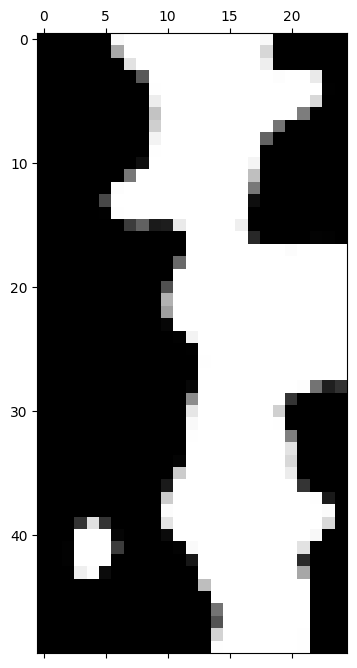

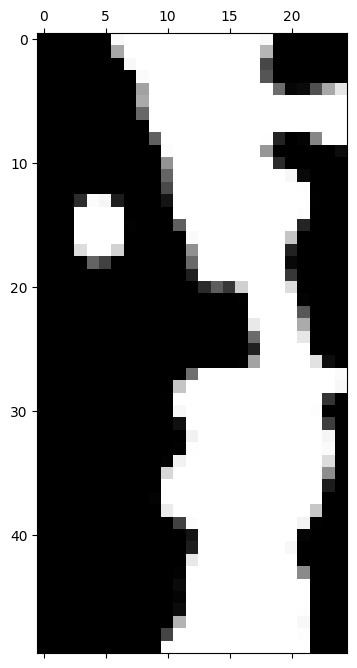

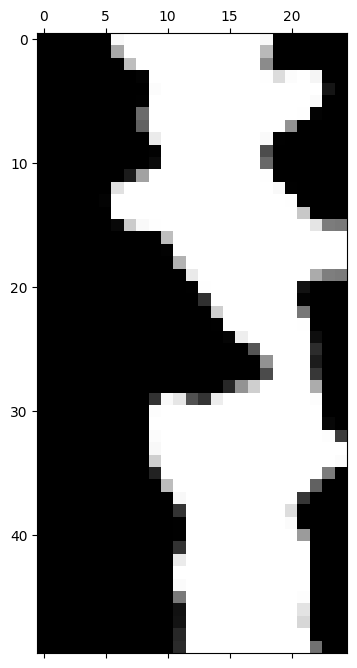

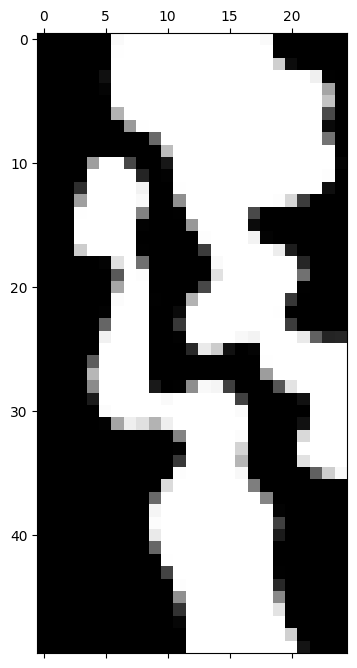

In [7]:
for i in range(4):
    plt.matshow(quarter_training_dataset_to[np.random.randint(len(quarter_training_dataset_to))], cmap='gray')

In [8]:
quarter_training_dataset_to=quarter_training_dataset_to.reshape(-1,1,2*down_scaled_width, down_scaled_width)
quarter_training_dataset_to.shape

torch.Size([517, 1, 50, 25])

In [9]:
quarter_training_dataset_to=torch.tensor(quarter_training_dataset_to, dtype=torch.float32)


/tmp/ipykernel_42/1961729854.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  quarter_training_dataset_to=torch.tensor(quarter_training_dataset_to, dtype=torch.float32)


In [10]:
my_dataset = TensorDataset(quarter_training_dataset_to) # create your datset


In [11]:
batch_size=47
train_loader = DataLoader(my_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


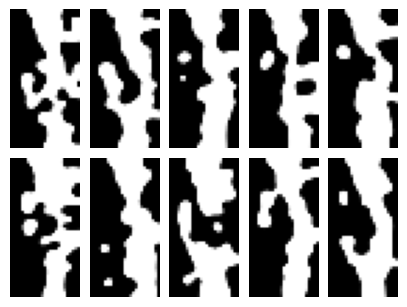

In [13]:
dataiter = iter(train_loader)
image = next(dataiter)

num_samples = 10
sample_images = [image[0][i,0] for i in range(num_samples)] 

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(2, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    #plt.matshow(im)

plt.show()

In [14]:
def design_recover(x): # for torch, replace np with torch
    top_left = x.reshape(int(down_scaled_width*2/2),int(down_scaled_width/2)) #x.reshape(200,100)
    bottom_left = np.flipud(top_left)
    top_right = np.fliplr(top_left)
    bottom_right = np.flipud(top_right)
    top_half = np.concatenate((top_left,top_right), axis=1)
    bottom_half = np.concatenate((bottom_left,bottom_right), axis=1)

    full_design = np.concatenate((top_half,bottom_half), axis=0)
    
    return full_design

In [15]:
##FOR IMPLEMENTING STRAIGHT THROUGH BVAE

class binarization(torch.autograd.Function):
    
    @staticmethod
    def forward(self,input):
        a=input.clone()
        a[a>0.5]=torch.tensor([1-(1e-5)])
        a[a<0.5]=torch.tensor([0+1e-5])
        return a

        
    @staticmethod
    def backward(self,grad_output):
        grad_input = grad_output.clone()
        return grad_i

In [16]:
class bVAE(nn.Module):
    def __init__(self,latent_dim):
        super(bVAE, self).__init__()

        self.encoder=nn.Sequential(
            nn.Linear(input_size,512),
            nn.LeakyReLU(0.1),
            nn.Dropout(p=0.3),

            nn.Linear(512,256),
            nn.LeakyReLU(0.1),
            nn.Dropout(p=0.3),

            nn.Linear(256,latent_dim),
            nn.LeakyReLU(0.1),
            #nn.Sigmoid(),
        )

        self.decoder=nn.Sequential(
            nn.Linear(latent_dim,256),
            nn.LeakyReLU(0.1),
            nn.Dropout(p=0.3),

            nn.Linear(256,512),
            nn.LeakyReLU(0.1),
            nn.Dropout(p=0.3),

            nn.Linear(512,input_size),
            nn.LeakyReLU(0.1),
            nn.Sigmoid()
        )
    

    def encode(self,x):
        a= self.encoder(x)
        a=torch.clamp(a,min=1e-5,max=1-1e-5)
        return a

    def gumbel_reparam(self,a,lambd): # takes in the input from the encoder
        lambd=lambd.to(DEVICE)
        a=torch.clamp(a,min=1e-5,max=1-1e-5).to(DEVICE)
        u=torch.clamp(torch.rand(a.size()),min=1e-5,max=1-1e-5).to(DEVICE)
        x=((torch.log(a/(1-a))+torch.log(u/(1-u)))/lambd).to(DEVICE)
        x=torch.sigmoid(x)
        x=torch.clamp(x,min=1e-5,max=1-1e-5)
        return x



    def decode(self,x):
        d=self.decoder(x)
        return d


    def forward(self,x):
        e=self.encode(x)
        g=self.gumbel_reparam(e,lambd)
        #b=binarization.apply(g)
        d=self.decode(g)
        return d,g,e, lambd

In [17]:
input_size=1250
latent_dim=100
LEARNING_RATE=1e-3

num_epochs=2000

lambd=torch.Tensor([5.0])
lambd_min=torch.Tensor([0.45])
lambd_learning_rate=torch.Tensor([3*1e-4])


model=bVAE(latent_dim)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

In [18]:

def loss_function(x,x_hat, a,beta=1.75):
    reconstruction_loss=torch.sum(torch.square(x-x_hat), axis=1) # shape = [batch_size]

    KL_loss= torch.sum(torch.log(torch.tensor(2.0)) + a*torch.log(a)+(1-a)*torch.log(1-a), axis=1) # size =[batch_size]
    total_loss=reconstruction_loss+beta*KL_loss
    return torch.mean(total_loss),torch.mean(reconstruction_loss),torch.mean(KL_loss)

def loss_function2(x,x_hat, a,beta=1):
    reconstruction_loss=nn.functional.binary_cross_entropy(x_hat, x, reduction='mean')
    
    prior = torch.tensor([0.5]*latent_dim).to(device)
 
    # Define the distributions
    dist_prior = torch.distributions.Bernoulli(prior)
    dist_a = torch.distributions.Bernoulli(a)
    
    # Calculate KL divergence
    #KL_loss = F.kl_div( torch.log(dist_a.probs),dist_prior.probs, reduction='batchmean')
    KL_loss = F.kl_div(torch.log(dist_prior.probs), dist_a.probs, reduction='batchmean')
    

    #KL_loss=torch.sum(latent_dim*np.log(2) + torch.sum(a*torch.log(a)+(1-a)*torch.log(1-a)))
    total_loss=reconstruction_loss+beta*KL_loss
    return total_loss,reconstruction_loss,KL_loss


In [19]:
#image = next(dataiter)
#image=torch.stack(image)
#image=image.view(-1, 1250)


In [20]:
#x_hat,gumbell,a, lam=model(image)

In [21]:
#KL_loss=torch.sum(torch.log(torch.tensor(2.0)) + a*torch.log(a)+(1-a)*torch.log(1-a), axis=1) # size =[batch_size]
#KL_loss.shape

In [22]:
l=[]
rloss=[]
klloss=[]
ll=[]
lmbd=lambd
lama=[]

def train(model, optimizer, epochs, device, x_dim=1250):
    model.train()
    global lambd
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, x in enumerate(train_loader):
            x=torch.stack(x)
            x = x.view(batch_size, x_dim).to(device)

            optimizer.zero_grad()

            x_hat,gumbell,a, lam=model(x)

            loss, rl, kl = loss_function(x, x_hat,a)
            l.append(loss)
            rloss.append(rl)
            klloss.append(kl)
            lama.append(lam)
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
        
        if lambd>lambd_min:
            lambd=lambd*np.exp(-lambd_learning_rate*i)
            ll.append(lambd)       
    return overall_loss

In [ ]:
train(model, optimizer, epochs=5000, device=device)


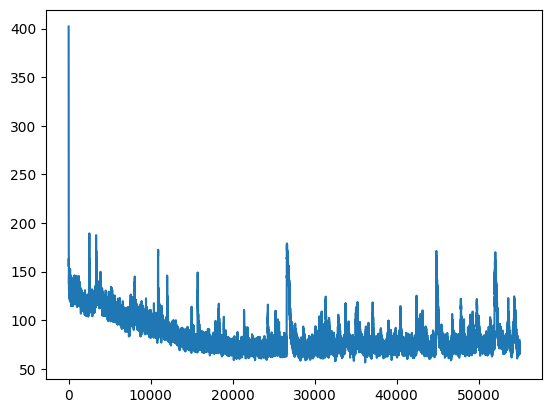

In [24]:
l=torch.tensor(l)
plt.plot(np.array(l.cpu().detach().numpy()))


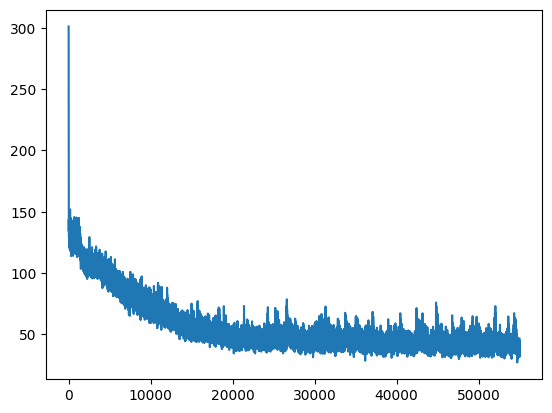

In [25]:
rloss=torch.tensor(rloss)
plt.plot(np.array(rloss.cpu().detach().numpy()))

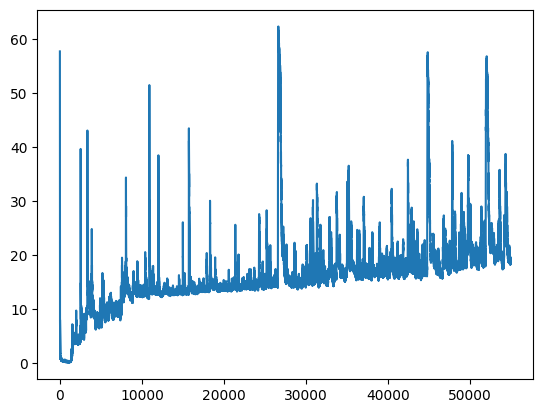

In [26]:
klloss=torch.tensor(klloss)
plt.plot(np.array(klloss.cpu().detach().numpy()))

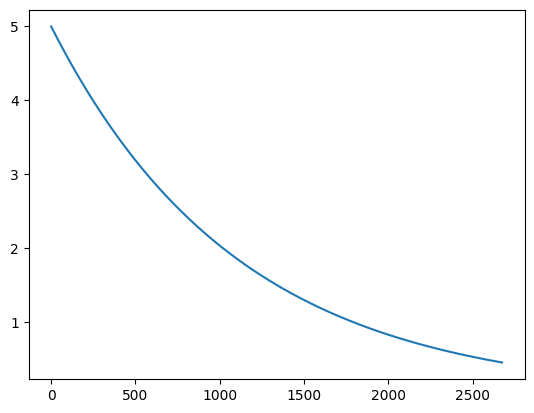

In [27]:
ll=torch.tensor(ll)
plt.plot(np.array(ll.cpu().detach().numpy()))


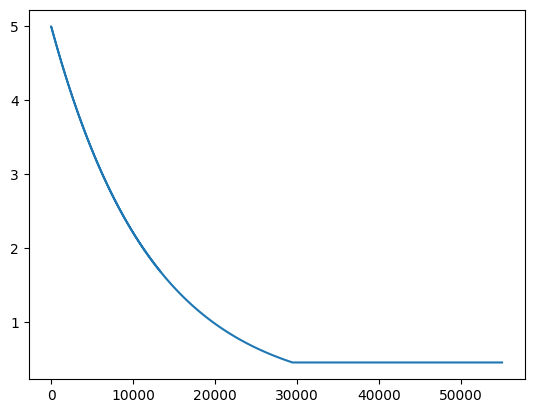

In [28]:
lama=torch.tensor(lama)
plt.plot(np.array(lama.cpu().detach().numpy()))


In [29]:
def design_recover(x): # for torch, replace np with torch
    top_left = x.reshape(int(down_scaled_width*2),int(down_scaled_width)) #x.reshape(200,100)
    bottom_left = np.flipud(top_left)
    top_right = np.fliplr(top_left)
    bottom_right = np.flipud(top_right)
    top_half = np.concatenate((top_left,top_right), axis=1)
    bottom_half = np.concatenate((bottom_left,bottom_right), axis=1)

    full_design = np.concatenate((top_half,bottom_half), axis=0)
    
    return full_design

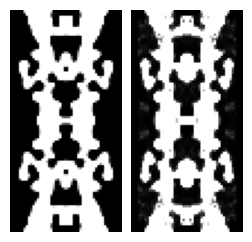

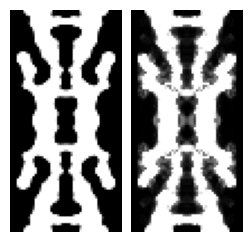

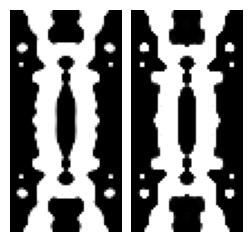

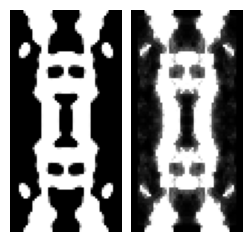

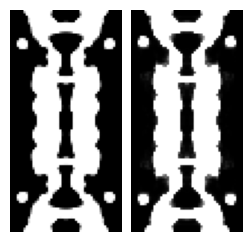

In [30]:
# Reconstruction check
#image = next(dataiter)

for i in range(5):
    input = image[0][i,0]
    output,g,a, _ =model(input.reshape(1,-1).to(DEVICE))
    output=output[0].detach().cpu().reshape(50,25)
    fig = plt.figure(figsize=(3, 3))
    grid = ImageGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=0.1)
    
    for ax, im in zip(grid, [design_recover(input), design_recover(output)]):
        ax.imshow(im, cmap='gray')
        ax.axis('off')
    plt.show()   

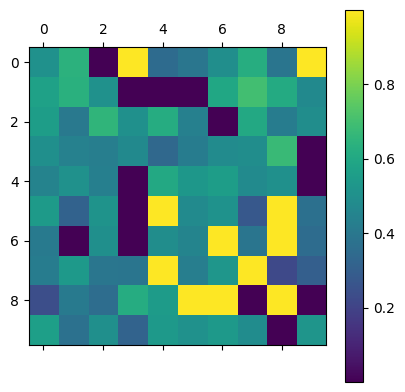

In [31]:
plt.matshow(a.reshape(10,-1).cpu().detach().numpy())
plt.colorbar()

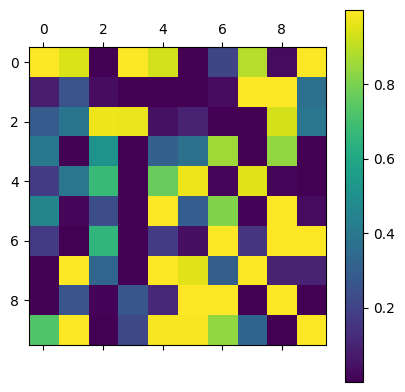

In [32]:
plt.matshow(g.reshape(10,-1).cpu().detach().numpy())
plt.colorbar()

In [33]:
def generate_design(zz):
    z_sample = zz.clone().detach()
    x_decoded = model.decode(z_sample)
    digit = x_decoded.detach().cpu().reshape(50, 25) # reshape vector to 2d array
    return digit


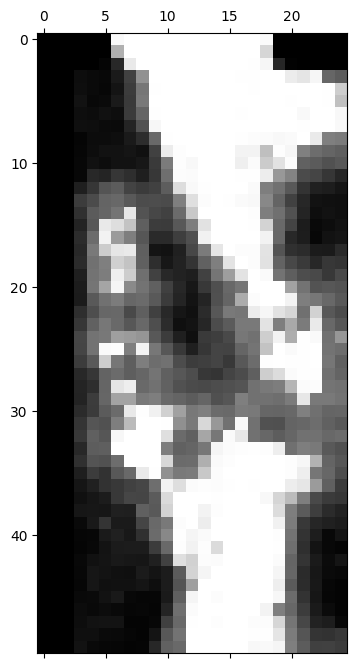

In [34]:
aa=torch.rand((latent_dim,))
b_sample=torch.bernoulli(aa) .to(DEVICE)
plt.matshow(generate_design(b_sample), cmap='gray')

In [35]:
z_s = np.random.rand(5)#np.zeros(10)

def plot_latent_space(model,sample_index1=2, sample_index2=3, scale=5.0, n=10, digit_size=25, figsize=15):
    # display a n*n 2D manifold of digits
    
    gap=5
    figure = np.zeros(((2*digit_size+2*gap) * n, (digit_size+2*gap) * n))
    
    # construct a grid 
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]
    
    z_s = np.random.rand(5)

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            aa=0.5*torch.ones((latent_dim,)) #torch.rand((latent_dim,))
            z_s=torch.bernoulli(aa) .to(DEVICE)
            z_sample = z_s.clone().detach()
            x_decoded = model.decode(z_sample)
            digit = x_decoded.detach().cpu().reshape(2*digit_size, digit_size)
            figure[i *(2*digit_size+2*gap)+gap : (i + 1) * (2*digit_size+2*gap)-gap, j *(1* digit_size+2*gap)+gap : (j + 1) *(1* digit_size+2*gap)-gap,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range_y = (2*digit_size + 2*gap)//2 #2*((digit_size+2*gap) // 2)
    end_range_y = n * (2*digit_size+2*gap) + start_range_y
    start_range_x = (digit_size+2*gap) // 2
    end_range_x = n * (digit_size+2*gap) + start_range_x
    pixel_range_x = np.arange(start_range_x, end_range_x, (digit_size+2*gap))
    pixel_range_y = np.arange(start_range_y, end_range_y, 2*(digit_size+gap))
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range_x, sample_range_x)
    plt.yticks(pixel_range_y, sample_range_y)
    plt.xlabel("latent node "+str(sample_index1)+' sweep')
    plt.ylabel("latent node " +str(sample_index2)+' sweep')
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

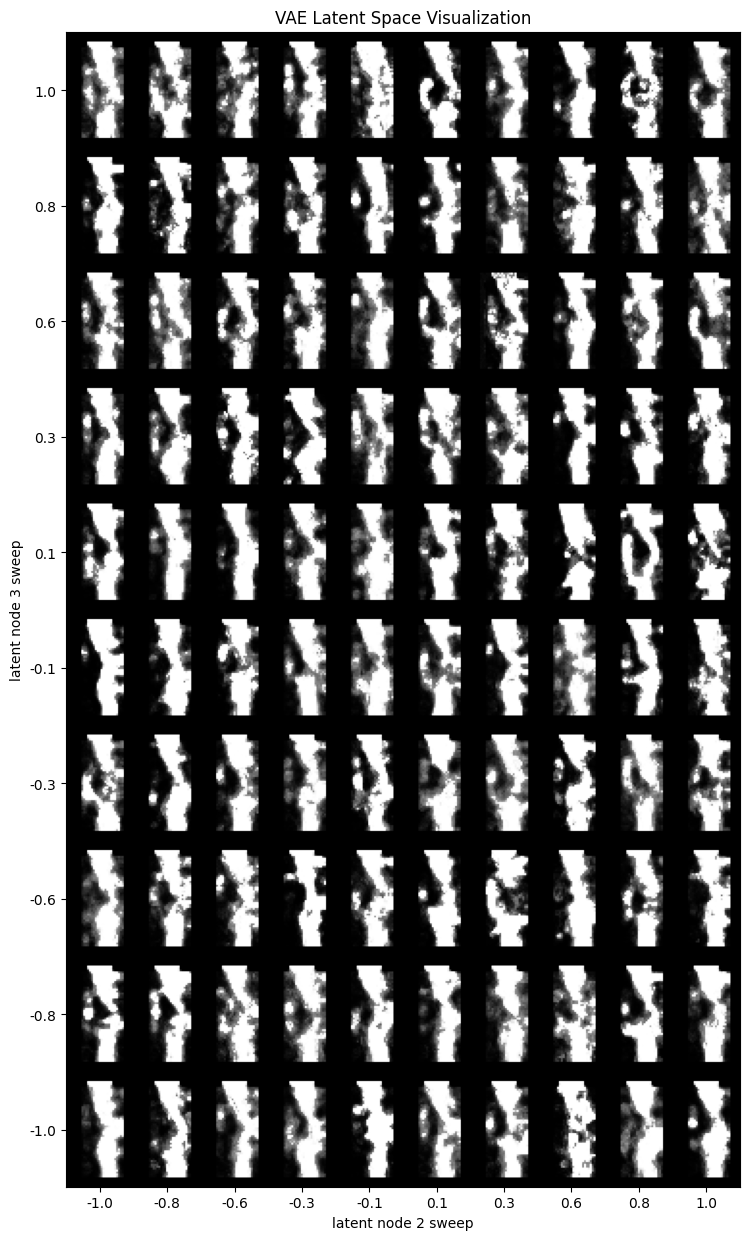

In [36]:
plot_latent_space(model, scale=1)


In [37]:

def plot_latent_space(model,sample_index1=3, sample_index2=1, scale=5.0, n=10, digit_size=25, figsize=20):
    # display a n*n 2D manifold of digits
    gap=12
    figure = np.zeros(((4*digit_size+2*gap) * n, (2*digit_size+2*gap) * n))
    
    # construct a grid 
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            aa=0.5*torch.ones((latent_dim,)) #torch.rand((latent_dim,))
            z_s=torch.bernoulli(aa) .to(DEVICE)
            z_sample = z_s.clone().detach()         
            x_decoded = model.decode(z_sample)
            digit = x_decoded.detach().cpu().reshape(2*digit_size, digit_size)
            digit = design_recover(digit)
            figure[i *(4*digit_size+2*gap)+gap : (i + 1) * (4*digit_size+2*gap)-gap, j *(2* digit_size+2*gap)+gap : (j + 1) *(2* digit_size+2*gap)-gap,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    digit_size=2*digit_size
    start_range_y = (2*digit_size + 2*gap)//2 #2*((digit_size+2*gap) // 2)
    end_range_y = n * (2*digit_size+2*gap) + start_range_y
    start_range_x = (digit_size+2*gap) // 2
    end_range_x = n * (digit_size+2*gap) + start_range_x
    pixel_range_x = np.arange(start_range_x, end_range_x, (digit_size+2*gap))
    pixel_range_y = np.arange(start_range_y, end_range_y, 2*(digit_size+gap))
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range_x, sample_range_x)
    plt.yticks(pixel_range_y, sample_range_y)
    plt.xlabel("latent node "+str(sample_index1)+' sweep')
    plt.ylabel("latent node " +str(sample_index2)+' sweep')
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

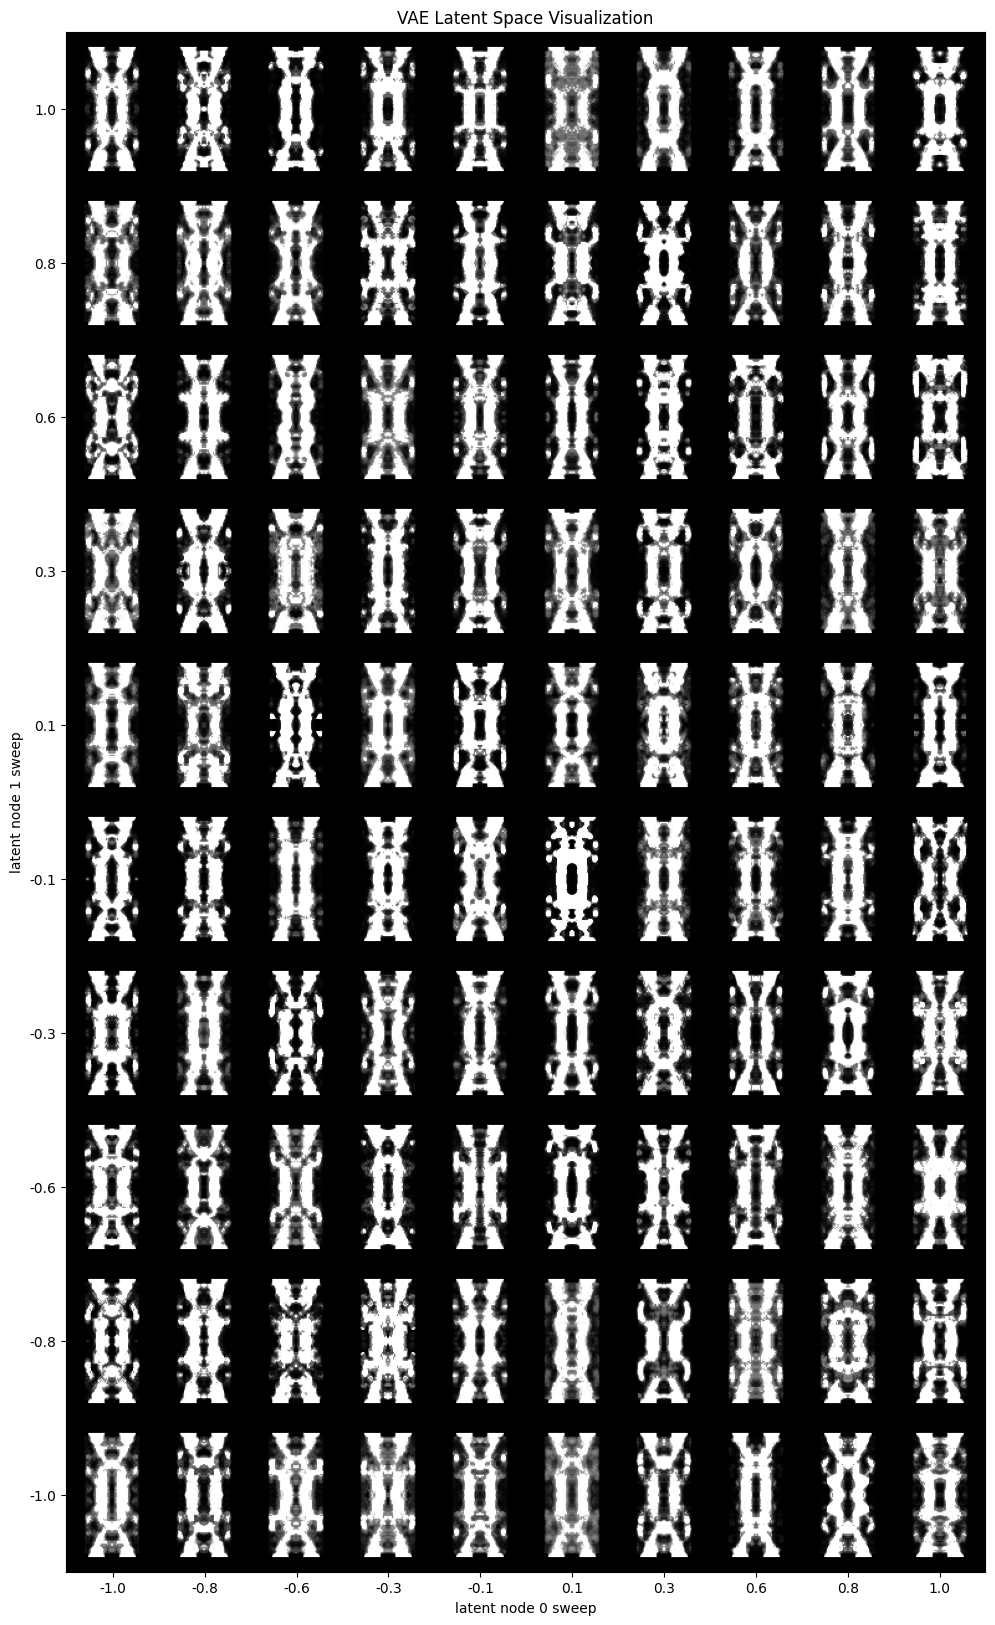

In [38]:
plot_latent_space(model, sample_index1=0,sample_index2=1,scale=1.0)


In [39]:
from scipy.ndimage import gaussian_filter

def projection(x, beta=torch.Tensor([32]), eta=torch.Tensor([0.5])):
    
    return (torch.tanh(beta*eta) + torch.tanh(beta*(x-eta))) / (torch.tanh(beta*eta) + torch.tanh(beta*(1-eta)))

In [40]:

def plot_latent_space(model,sample_index1=3, sample_index2=1, scale=5.0, n=10, digit_size=25, figsize=20):
    # display a n*n 2D manifold of digits
    gap=12
    figure = np.zeros(((4*digit_size+2*gap) * n, (2*digit_size+2*gap) * n))
    
    # construct a grid 
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            aa=0.5*torch.ones((latent_dim,)) #torch.rand((latent_dim,))
            z_s=torch.bernoulli(aa) .to(DEVICE)
            z_sample = z_s.clone().detach()         
            x_decoded = model.decode(z_sample)
            digit = x_decoded.detach().cpu().reshape(2*digit_size, digit_size)
            digit = design_recover(digit)
            digit=gaussian_filter(digit, sigma=1.5)#
            digit=projection(torch.Tensor(digit))#
            figure[i *(4*digit_size+2*gap)+gap : (i + 1) * (4*digit_size+2*gap)-gap, j *(2* digit_size+2*gap)+gap : (j + 1) *(2* digit_size+2*gap)-gap,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    digit_size=2*digit_size
    start_range_y = (2*digit_size + 2*gap)//2 #2*((digit_size+2*gap) // 2)
    end_range_y = n * (2*digit_size+2*gap) + start_range_y
    start_range_x = (digit_size+2*gap) // 2
    end_range_x = n * (digit_size+2*gap) + start_range_x
    pixel_range_x = np.arange(start_range_x, end_range_x, (digit_size+2*gap))
    pixel_range_y = np.arange(start_range_y, end_range_y, 2*(digit_size+gap))
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range_x, sample_range_x)
    plt.yticks(pixel_range_y, sample_range_y)
    plt.xlabel("latent node "+str(sample_index1)+' sweep')
    plt.ylabel("latent node " +str(sample_index2)+' sweep')
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

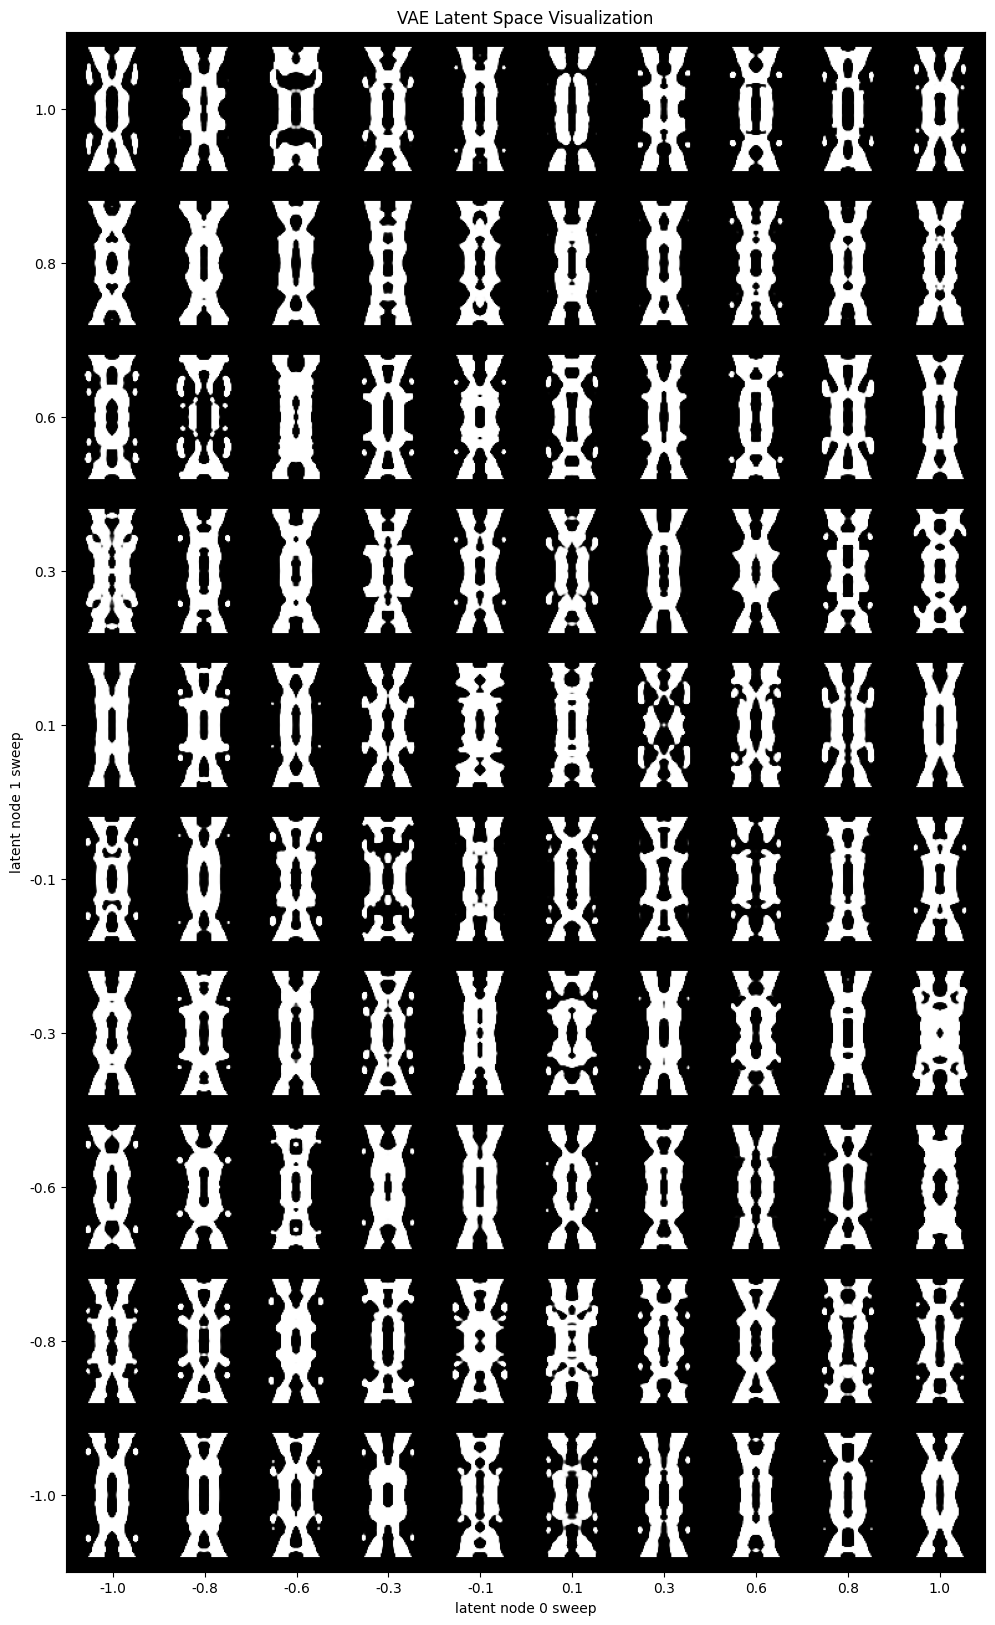

In [41]:
plot_latent_space(model, sample_index1=0,sample_index2=1,scale=1.0)
